# Import

In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib
matplotlib.__version__

'3.0.0'

In [4]:
np.__version__, pd.__version__

('1.15.2', '0.23.4')

# Dataset:

In [5]:
from sklearn.datasets import california_housing

data = california_housing.fetch_california_housing()

X = data['data']
y = data['target']
columns = data['feature_names']

train_df = pd.DataFrame(X, index=np.arange(len(X)), columns=columns)
train_df['target'] = y
train_df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


# 1) Initialize:

In [6]:
#import sys

#sys.path.append('../SWMat/')
from SWMat import SWMat

In [7]:
from matplotlib.patches import Wedge, Polygon
from matplotlib.collections import PatchCollection

["\\> Communicating <prop color='#3b5998' fontsize='30'>Data</prop>Effectively."]


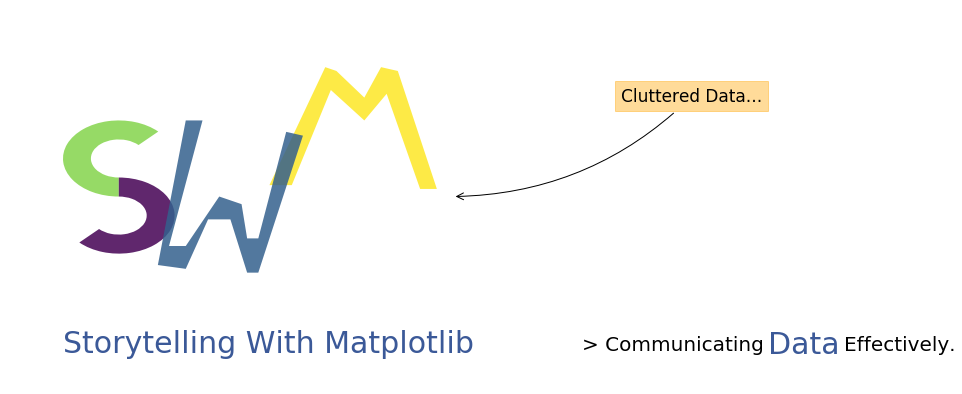

In [8]:
fig = plt.figure(figsize=(10, 7))

ax = plt.gca()
for pos in ["right", "left", "top", "bottom"]:
    ax.spines[pos].set_visible(False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
patches = []

patches += [Wedge((.2, .6), .1, 45, 270, width=0.05),
            Wedge((.2, .45), .1, 225, 450, width=0.05),
            Polygon(np.array([[.22, .23], [.26, .23], [.33, .48], [.39, .40], [.43, .47], [.49, .22], 
                              [.52, .22], [.45, .53], [.42, .54], [.39, .46], [.34, .53], [.32, .54]]) + np.array([0.25, 0.3])),
           Polygon(np.array([[.32, .70], [.27, .32], [.32, .31], [.36, .44], [.40, .44], [.43, .30], [.45, .30],
                            [.53, .66], [.50, .67], [.45, .39], [.43, .39], [.42, .48], [.38, .50], [.32, .37], [.29, .37], [.35, .70]]))
           ]

colors = 100*np.random.rand(len(patches))

p = PatchCollection(patches, alpha=0.85)
p.set_array(np.array(colors))
ax.add_collection(p);

plt.text(0.1, 0.09, "Storytelling With Matplotlib", fontsize=30, color="#3b5998")

plt.annotate("Cluttered Data...", xy=(.8, .5), xytext=(1.1, .75),
             arrowprops={'arrowstyle':'->', 'color': 'black', 
                         "connectionstyle":"arc3,rad=-0.2"},
             bbox={'pad':6, 'edgecolor':'orange', 'facecolor': 
                   'orange', 'alpha':0.4}, fontsize=17)
#plt.text(x=1.3, y=.1, s="Communicating Data\nEffectively.", fontsize=20, ha="center")
swm = SWMat(plt, ax=ax)
swm.text("\> Communicating <prop color='#3b5998' fontsize='30'>Data</prop>Effectively.", fontsize=20, 
         position="out-lower-right");

['Here goes your text!', "<prop color='blue'>yoyoyoyoyo<\\prop>", 'puneet', 'yo']


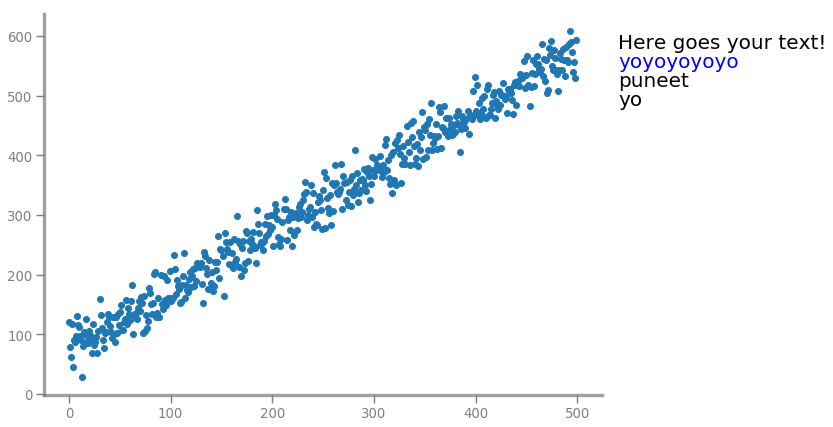

In [9]:
# Simple Text

swm = SWMat(plt) # And... base beautifications will be added.
y = np.arange(500) + np.random.random(500)*50 + np.random.random(500)*40 + np.random.random(500)*50 + np.random.random(500)*10
x = np.arange(500)
plt.scatter(x, y)
swm.text("Here goes your text!\n<prop color='blue'>yoyoyoyoyo<\prop>\npuneet\nyo", fontsize=20);

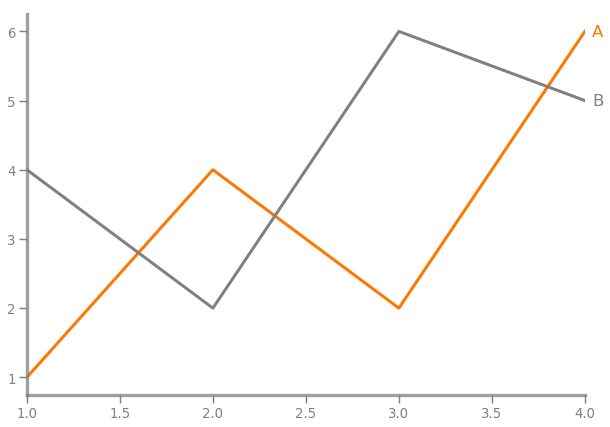

In [10]:
swm = SWMat(plt)
ls = swm.line_plot(np.array([[1, 2, 3, 4], [1, 2, 3, 4]]).T, np.array([[1, 4, 2, 6], [4, 2, 6, 5]]).T, line_labels=["A", "B"],
                  highlight=0, lw=3)

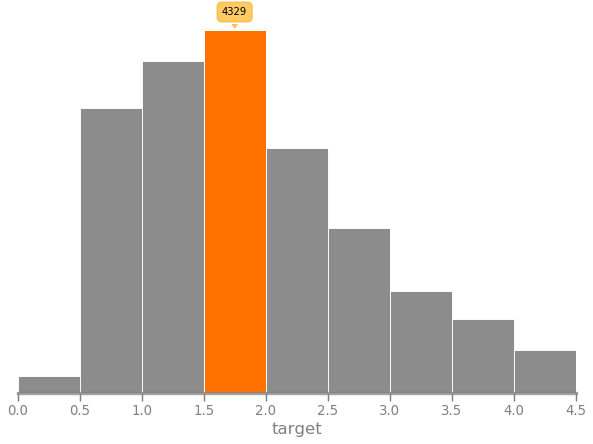

In [34]:
swm = SWMat(plt)
hist = swm.hist(train_df['target'], highlight=3, bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5], ec='w', hide_y=True)
#t = swm.text("My first text!<prop>Possible Outliers</prop><prop>haleluya\nyo lib ipsum dipsum</prop>\nipsum", 
#             fontsize=18)

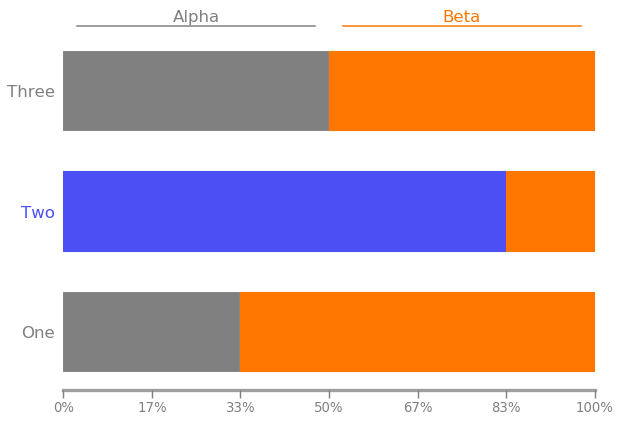

In [15]:
swm = SWMat(plt)
swm.bar(np.array([[1, 2, 3], [1, 2, 3]]), np.array([[2, 5, 3], [4, 1, 3]]), data_labels=["Alpha", "Beta"],  highlight={"data":1, "cat":1},
        cat_labels=["One", "Two", "Three"], plot_type="stacked100%", width=0.8);

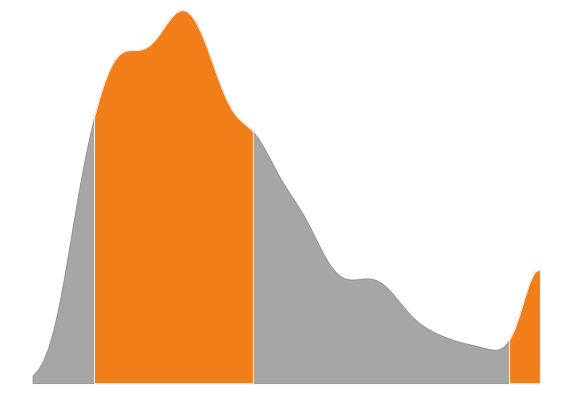

In [9]:
swm = SWMat(plt)
v = swm.violinplot(train_df['target'], show="top", highlight={"0":[(0.7, 2.3), (4.7, 6)]})

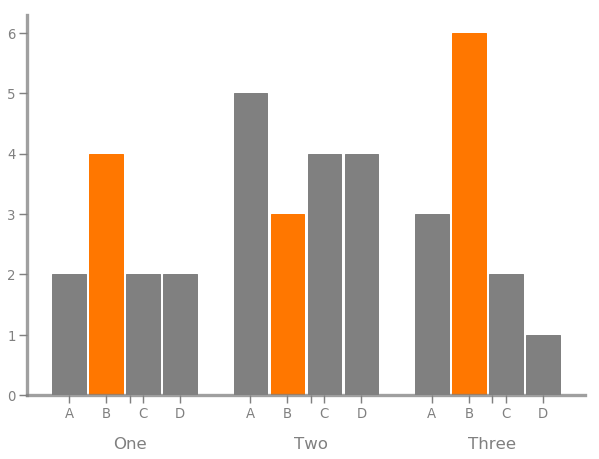

In [11]:
swm = SWMat(plt)
swm.bar(np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([[2, 5, 3], [4, 3, 6], [2, 4, 2], [2, 4, 1]]), data_labels=["A", "B", "C", "D"], cat_labels=["One", "Two", "Three"], highlight={"data":1});

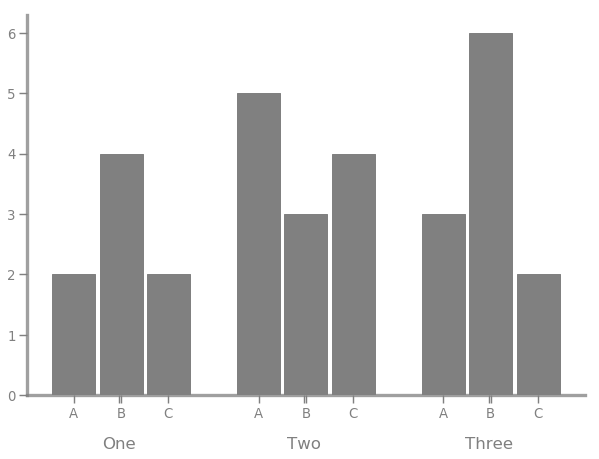

In [14]:
swm = SWMat(plt)
swm.bar(np.array([[1, 2, 3], [1, 2, 3], [1, 2, 3]]), np.array([[2, 5, 3], [4, 3, 6], [2, 4, 2]]), data_labels=["A", "B", "C"], cat_labels=["One", "Two", "Three"]);